## B. Implement 2D Convolution in Python (no libraries)

### 2. Vectorisation, no for loops

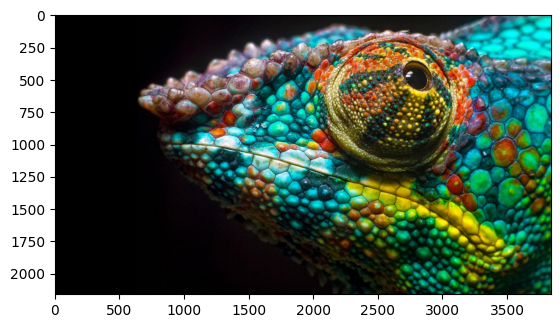

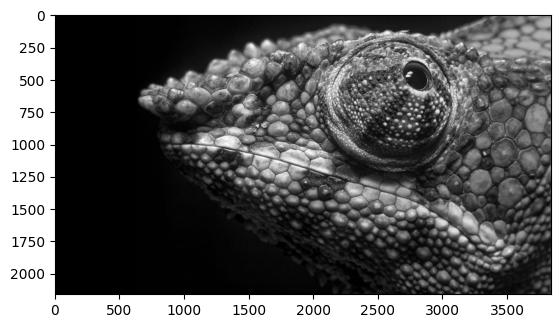

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

org = cv2.imread('../../images/chameleon.jpg')
plt.imshow(cv2.cvtColor(org,cv2.COLOR_BGR2RGB))
plt.show()
greyorg = cv2.cvtColor(org,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(greyorg,cv2.COLOR_BGR2RGB))
plt.show()


In [3]:
greyorg.shape

(2160, 3840)

In [3]:
def toeplitz(vector):
    matrix = np.zeros((vector.size,vector.size-1))
    for i in range(vector.size): # rows
        for j in range(vector.size - 1): # columns
            if i-j >= 0:
                matrix[i][j] = vector[i-j]
            else:
                matrix[i][j] = 0
    return matrix

In [4]:
print(toeplitz(np.array([30,40,20,10])))

NameError: name 'toeplitz' is not defined

In [5]:
# 2d convolution using matrix multiplication
# Done by creating a doubly blocked circulant matrix using toeplitz matrices for each row of the filter with the elements of the convolution matrix K, keeping all other elements of the matrix as 0,
# and converting the input image channel M into a column vector of size N times M
"""import numpy as np

def create_toeplitz(vector, rows, columns):
    # check if vector is an array or a matrix
    if np.isscalar(vector[0]):  # Handle scalar values
        matrix = np.zeros((rows, columns))
    else:  # Handle vector[0] as a matrix
        matrix = np.zeros((rows, columns), dtype=object)
        
    for i in range(rows):
        for j in range(columns):
            if i - j >= 0:
                print(i, j)
                matrix[i][j] = vector[i - j]
            else:
                if np.isscalar(vector[0]):
                    matrix[i][j] = 0
                else:
                    matrix[i][j] = np.zeros_like(vector[0])  # Set to a zero matrix if same shape as a row toeplitz
    return matrix

def filter_matrix(k,matrsize, num_rows, num_columns):
    # create convolution matrix
    k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
    # create toeplitz matrix for each row
    rows_toeplitz = []
    for i in range(num_rows):
        toeplitz_row = create_toeplitz(k[i],k.shape[0],k.shape[1]-1)
        rows_toeplitz.append(toeplitz_row)

    # create doubly blocked circulant matrix using the row toeplitz matrices
    filter = create_toeplitz(rows_toeplitz,np.array(rows_toeplitz).size,np.array(rows_toeplitz).size-1)
    return filter

def convovle(img,matrsize):
    # create convolution matrix
    k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
    
    # define the convolution
    y = img.flatten()
    num_columns = img.shape[0]*img.shape[1]
    num_rows = matrsize
    filter = filter_matrix(k,matrsize,num_rows,num_columns)
    y = np.matmul(filter,y)

    # reshape y to image
    y = np.reshape(y,(img.shape[0],img.shape[1]))
    return y"""

In [7]:
import numpy as np
def create_toeplitz(vector, rows, columns):
    matrix = np.zeros((rows, columns))
    for i in range(rows):
        for j in range(columns):
            if i - j >= 0:
                matrix[i][j] = vector[i - j]
            else:
                matrix[i][j] = 0
    return matrix

def filter_matrix(k, matrsize, num_rows, num_columns):
    # Create Toeplitz matrices for each row
    rows_toeplitz = []
    for i in range(matrsize):
        row_vec = np.pad(k[i], (0, num_columns - matrsize), 'constant')  # Pad to ensure the correct size
        toeplitz_row = create_toeplitz(row_vec, num_columns, num_columns)
        rows_toeplitz.append(toeplitz_row)

    # Stack row Toeplitz matrices to form the doubly blocked circulant matrix
    filter_matrix = np.block([[rows_toeplitz[i] if i == j else np.zeros_like(rows_toeplitz[0]) for j in range(matrsize)] for i in range(matrsize)])
    
    return filter_matrix

def convolve(img, matrsize):
    # Create convolution matrix
    k = 1/(matrsize*matrsize) * np.ones((matrsize, matrsize))
    
    # Flatten the image and get filter matrix
    y = img.flatten()
    num_columns = img.shape[0] * img.shape[1]
    filter = filter_matrix(k, matrsize, num_columns, num_columns)
    
    # Perform matrix multiplication
    y = np.matmul(filter, y)
    
    # Reshape result back into image
    y = np.reshape(y, img.shape)
    return y

In [8]:
import numpy as np
from scipy.linalg import toeplitz


def matrix_to_vector(input):
    """
    Converts the input matrix to a vector by stacking the rows in a specific way explained here
    
    Arg:
    input -- a numpy matrix
    
    Returns:
    ouput_vector -- a column vector with size input.shape[0]*input.shape[1]
    """
    input_h, input_w = input.shape
    output_vector = np.zeros(input_h*input_w, dtype=input.dtype)
    # flip the input matrix up-down because last row should go first
    input = np.flipud(input) 
    for i,row in enumerate(input):
        st = i*input_w
        nd = st + input_w
        output_vector[st:nd] = row   
    return output_vector


def vector_to_matrix(input, output_shape):
    """
    Reshapes the output of the maxtrix multiplication to the shape "output_shape"
    
    Arg:
    input -- a numpy vector
    
    Returns:
    output -- numpy matrix with shape "output_shape"
    """
    output_h, output_w = output_shape
    output = np.zeros(output_shape, dtype=input.dtype)
    for i in range(output_h):
        st = i*output_w
        nd = st + output_w
        output[i, :] = input[st:nd]
    # flip the output matrix up-down to get correct result
    output=np.flipud(output)
    return output


def convolution_as_maultiplication(I, F, print_ir=False):
    """
    Performs 2D convolution between input I and filter F by converting the F to a toeplitz matrix and multiply it
      with vectorizes version of I
      By : AliSaaalehi@gmail.com
      
    Arg:
    I -- 2D numpy matrix
    F -- numpy 2D matrix
    print_ir -- if True, all intermediate resutls will be printed after each step of the algorithms
    
    Returns: 
    output -- 2D numpy matrix, result of convolving I with F
    """
    # number of columns and rows of the input 
    I_row_num, I_col_num = I.shape 

    # number of columns and rows of the filter
    F_row_num, F_col_num = F.shape

    #  calculate the output dimensions
    output_row_num = I_row_num + F_row_num - 1
    output_col_num = I_col_num + F_col_num - 1
    if print_ir: print('output dimension:', output_row_num, output_col_num)

    # zero pad the filter
    F_zero_padded = np.pad(F, ((output_row_num - F_row_num, 0),
                               (0, output_col_num - F_col_num)),
                            'constant', constant_values=0)
    if print_ir: print('F_zero_padded: ', F_zero_padded)

    # use each row of the zero-padded F to creat a toeplitz matrix. 
    #  Number of columns in this matrices are same as numbe of columns of input signal
    toeplitz_list = []
    for i in range(F_zero_padded.shape[0]-1, -1, -1): # iterate from last row to the first row
        c = F_zero_padded[i, :] # i th row of the F 
        r = np.r_[c[0], np.zeros(I_col_num-1)] # first row for the toeplitz fuction should be defined otherwise
                                                            # the result is wrong
        toeplitz_m = toeplitz(c,r) # this function is in scipy.linalg library
        toeplitz_list.append(toeplitz_m)
        if print_ir: print('F '+ str(i)+'\n', toeplitz_m)

        # doubly blocked toeplitz indices: 
    #  this matrix defines which toeplitz matrix from toeplitz_list goes to which part of the doubly blocked
    c = range(1, F_zero_padded.shape[0]+1)
    r = np.r_[c[0], np.zeros(I_row_num-1, dtype=int)]
    doubly_indices = toeplitz(c, r)
    if print_ir: print('doubly indices \n', doubly_indices)

    ## creat doubly blocked matrix with zero values
    toeplitz_shape = toeplitz_list[0].shape # shape of one toeplitz matrix
    h = toeplitz_shape[0]*doubly_indices.shape[0]
    w = toeplitz_shape[1]*doubly_indices.shape[1]
    doubly_blocked_shape = [h, w]
    doubly_blocked = np.zeros(doubly_blocked_shape)

    # tile toeplitz matrices for each row in the doubly blocked matrix
    b_h, b_w = toeplitz_shape # hight and withs of each block
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * b_h
            start_j = j * b_w
            end_i = start_i + b_h
            end_j = start_j + b_w
            doubly_blocked[start_i: end_i, start_j:end_j] = toeplitz_list[doubly_indices[i,j]-1]

    if print_ir: print('doubly_blocked: ', doubly_blocked)

    # convert I to a vector
    vectorized_I = matrix_to_vector(I)
    if print_ir: print('vectorized_I: ', vectorized_I)
    
    # get result of the convolution by matrix mupltiplication
    result_vector = np.matmul(doubly_blocked, vectorized_I)
    if print_ir: print('result_vector: ', result_vector)

    # reshape the raw rsult to desired matrix form
    out_shape = [output_row_num, output_col_num]
    output = vector_to_matrix(result_vector, out_shape)
    if print_ir: print('Result of implemented method: \n', output)
    
    return output

In [44]:
# greyorg_resized = cv2.resize(greyorg, (greyorg.shape[1]//26,greyorg.shape[0]//26))
greyorg_resized = cv2.resize(greyorg, (greyorg.shape[1]//18,greyorg.shape[0]//18))
print(greyorg_resized.shape)

(120, 213)


In [ ]:
vanillaconvolved = convolve(greyorg,3)
matrsize = 3
k = np.array(1/(matrsize*matrsize)*np.array([[i+j for i in range(matrsize)] for j in range(matrsize)]))
print(k.shape)

In [42]:
from time import time
# I = np.random.randn(80, 85)
matrsize = 3
k = np.array(1/(matrsize*matrsize)*np.array([[i+j for i in range(matrsize)] for j in range(matrsize)]))
start = time()
my_result = convolution_as_maultiplication(greyorg_resized, k)
time_vanillaconv = time() - start
print('my result: \n', my_result)
    
from scipy import signal
start = time()
lib_result = signal.convolve2d(greyorg_resized, k, "full")
time_libconv = time() - start
print('lib result: \n', lib_result)

assert(my_result.all() == lib_result.all())

print(time_vanillaconv,time_libconv,time_vanillaconv-time_libconv,end="\n")

my result: 
 [[  0.           0.           0.         ...  43.66666667  47.33333333
   31.11111111]
 [  0.           0.           0.         ... 136.77777778 126.77777778
   77.77777778]
 [  0.           0.           0.         ... 287.33333333 248.55555556
  147.33333333]
 ...
 [  0.           0.           0.         ... 108.22222222  71.88888889
   58.11111111]
 [  0.           0.           0.         ...  92.77777778  60.55555556
   39.        ]
 [  0.           0.           0.         ...  47.11111111  38.55555556
   21.77777778]]
lib result: 
 [[  0.           0.           0.         ...  43.66666667  47.33333333
   31.11111111]
 [  0.           0.           0.         ... 136.77777778 126.77777778
   77.77777778]
 [  0.           0.           0.         ... 287.33333333 248.55555556
  147.33333333]
 ...
 [  0.           0.           0.         ... 108.22222222  71.88888889
   58.11111111]
 [  0.           0.           0.         ...  92.77777778  60.55555556
   39.        ]
 [  0

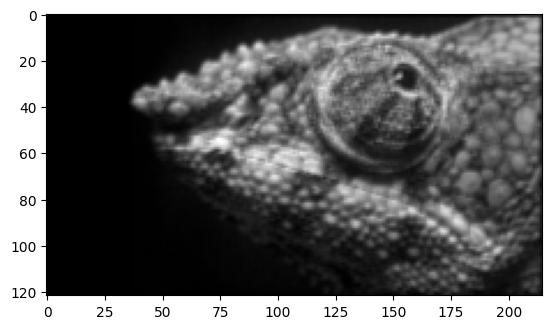

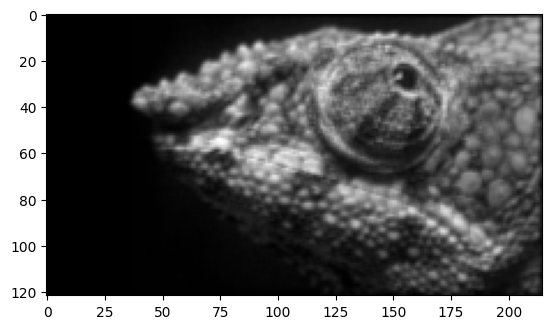

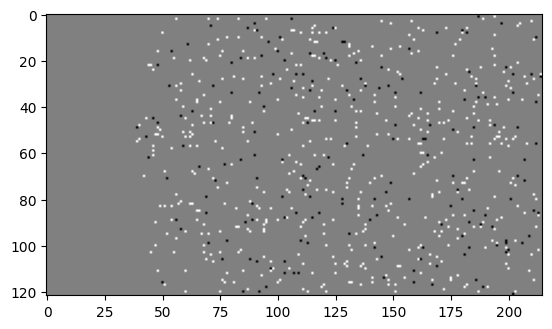

In [43]:
plt.imshow(my_result.astype(np.int64),cmap='gray')
plt.show()
plt.imshow(lib_result.astype(np.int64),cmap='gray')
plt.show()
plt.imshow((my_result.astype(np.int64) - lib_result.astype(np.int64)),cmap='gray')

In [38]:
print(my_result == lib_result)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True False  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ... False  True  True]]


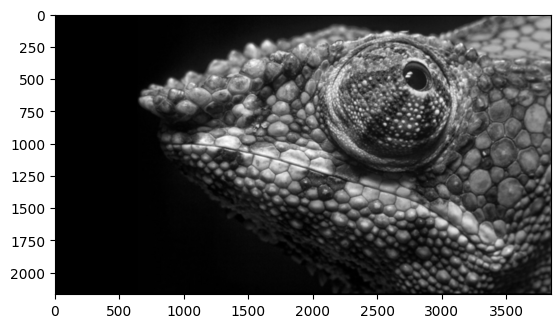

In [49]:
from scipy import signal
matrsize = 10
k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
librayconvolved = signal.convolve2d(greyorg, k, 'full')
plt.imshow(librayconvolved,cmap='gray')

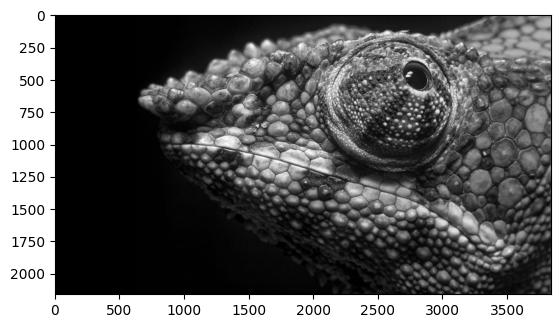

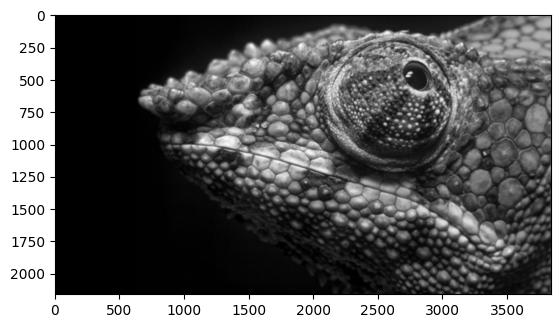

In [50]:
import cv2
matrsize = 10
cv2blurred = cv2.blur(greyorg,(10,10))
plt.imshow(cv2.cvtColor(greyorg,cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(cv2blurred,cv2.COLOR_BGR2RGB))
plt.show()

### 3. Using FFT 

/var/folders/vg/c0z21yg92qd0jhn0p09c9x200000gp/T/ipykernel_46249/2321416655.py:15: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(fftshift(filter_fourier))))
/var/folders/vg/c0z21yg92qd0jhn0p09c9x200000gp/T/ipykernel_46249/2321416655.py:20: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(fftshift(fftconv))))


(2160, 3840)


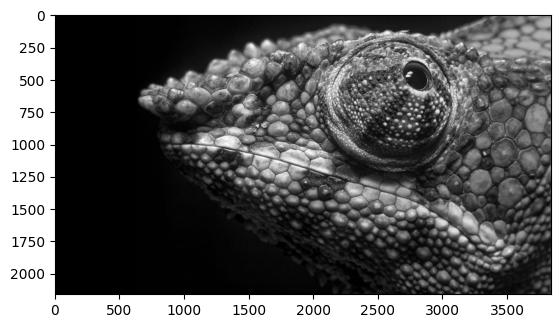

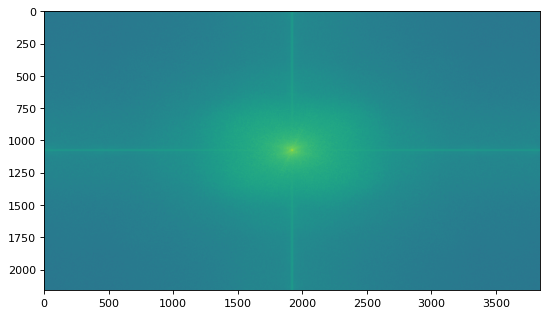

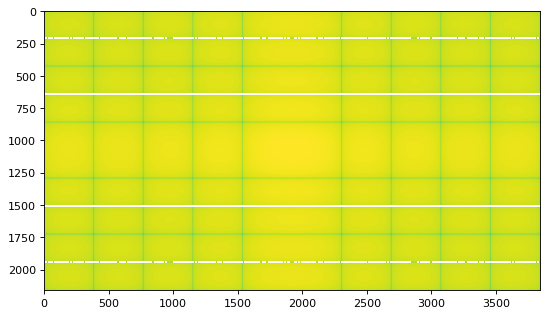

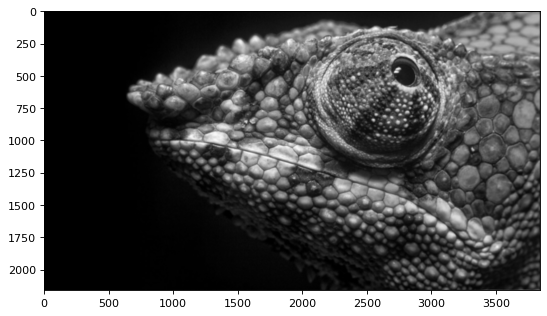

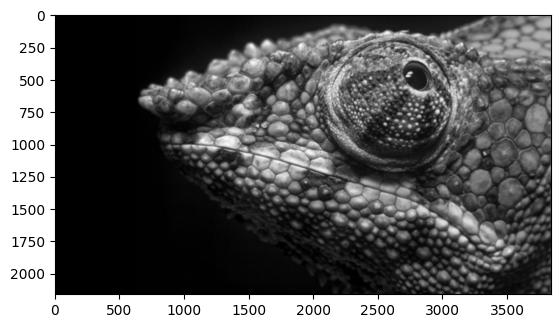

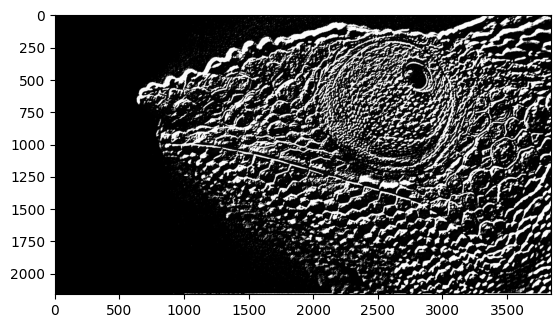

In [51]:
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import uniform_filter

matrsize = 10

plt.imshow(cv2.cvtColor(greyorg,cv2.COLOR_BGR2RGB))
grey_fourier = fft2(greyorg)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(fftshift(grey_fourier))))
# create filter matrix
k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
k_padded = np.pad(k, ((int(np.floor((greyorg.shape[0] - k.shape[0]) / 2)),int(np.ceil((greyorg.shape[0] - k.shape[0]) / 2))), (int(np.floor((greyorg.shape[1] - k.shape[1]) / 2)),int(np.ceil((greyorg.shape[1] - k.shape[1]) / 2)))))
filter_fourier = fft2(k_padded)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(fftshift(filter_fourier))))

# convolution through fft multiplication
fftconv = grey_fourier*filter_fourier
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(fftshift(fftconv))))

# inverse fft
convolved = np.abs(fftshift(ifft2(fftconv))).astype(np.uint8)
print(convolved.shape)
plt.imshow(cv2.cvtColor(convolved,cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(cv2blurred,cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(cv2blurred - convolved,cv2.COLOR_BGR2RGB))

In [56]:
# Time comparison
from time import time
import cv2

# Using FFT:

start = time()
k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
k_padded = np.pad(k, ((int(np.floor((greyorg.shape[0] - k.shape[0]) / 2)),int(np.ceil((greyorg.shape[0] - k.shape[0]) / 2))), (int(np.floor((greyorg.shape[1] - k.shape[1]) / 2)),int(np.ceil((greyorg.shape[1] - k.shape[1]) / 2)))))
filter_fourier = fft2(k_padded)

# convolution through fft multiplication
fftconv = grey_fourier*filter_fourier

# inverse fft
convolved = np.abs(fftshift(ifft2(fftconv))).astype(np.uint8)
fft_time = time() - start

print("FFT:",fft_time, "(Implemented in python)")

# Using scipy:
start = time()
librayconvolved = cv2.blur(greyorg,(10,10))
cv2blur_time = time() - start
print("CV2 Blur:",cv2blur_time,"(Built in C++)")

FFT: 0.26147890090942383 (Implemented in python)
CV2 Blur: 0.005525112152099609 (Built in C++)


### Difference in the outputs:

Both, the FFT implementation and the cv2.blur() libary implementation use the moving average filter as the kernel.

However, there is a difference in the outputs of the two. This can be because of precision errors which arise due to numerical approximations in the FFT, especially when converting back from the frequency domain to the spaicl domain of the image, which can result in small differences in the intensity values of the pixels.

Additionally, differences can arise because of the circular convolution used in the FFT instead of the linear convolution of the spacial moving average filter.